Use Efficientnet classifier to test SIFT.

Slices one 65x64 patch out of the middle of each dog picture, SIFTs that and pushes the SIFT descriptor through a small Dense network. Demonstrates training.

In [1]:
import numpy as np
import tensorflow as tf
import keras

In [2]:
!pip uninstall -y keras-sift
!pip install -qq git+https://github.com/LanceNorskog/keras-sift.git
from keras_sift import getSIFTModel

In [3]:
model = getSIFTModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65, 65, 1)]  0                                            
__________________________________________________________________________________________________
gx_609380 (Conv2D)              (None, 63, 65, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
gy_768087 (Conv2D)              (None, 65, 63, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 65, 65, 1)    0           gx_609380[0][0]                  
______________________________________________________________________________________________

In [4]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 256
PATCH_SIZE = 65

import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

size = (IMG_SIZE, IMG_SIZE)
ds_sample = ds_train.map(lambda image, label: (tf.image.rgb_to_grayscale(tf.image.resize(image, size)), label))
ds_train_orig = ds_train.map(lambda image, label: (tf.image.crop_to_bounding_box(tf.image.rgb_to_grayscale(tf.image.resize(image, size)), 128, 128, PATCH_SIZE, PATCH_SIZE), label))
ds_test_orig = ds_test.map(lambda image, label: (tf.image.crop_to_bounding_box(tf.image.rgb_to_grayscale(tf.image.resize(image, size)), 128, 128, PATCH_SIZE, PATCH_SIZE), label))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZZRU0C/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZZRU0C/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Break image into overlapping patches

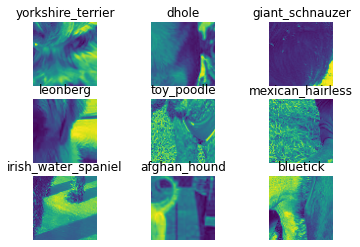

In [5]:
import matplotlib.pyplot as plt

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train_orig.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    dog = image.numpy().astype("uint8")
    gray = np.reshape(image.numpy().astype("uint8"), (PATCH_SIZE, PATCH_SIZE))
    plt.imshow(gray)
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


In [6]:
chopped = [[
  [[0,0],[65,65]],
  [[0,33],[65,64+33]],
  [[0,64],[65,64+65]],
  [[0,96],[65,96+65]],
  [[0,128],[65,128+65]],
  [[0,160],[65,160+65]],
  [[0,192],[65,192+64]],
  ], [
  [[32,0],[65+32,65]],
  [[32,33],[65+32,65+32]],
  [[32,64],[65+32,64+65]],
  [[32,96],[65+32,96+65]],
  [[32,128],[65+32,128+65]],
  [[32,160],[65+32,160+65]],
  [[32,192],[65+32,192+65]],
  ], [

  [[64,0],[65+64,65]],
  [[64,33],[65+64,65+32]],
  [[64,64],[65+64,64+65]],
  [[64,96],[65+64,96+65]],
  [[64,128],[65+64,128+65]],
  [[64,160],[65+64,160+65]],
  [[64,192],[65+64,192+65]],
  ], [

  [[96,0],[65+96,65]],
  [[96,33],[65+96,65+32]],
  [[96,64],[65+96,64+65]],
  [[96,96],[65+96,96+65]],
  [[96,128],[65+96,128+65]],
  [[96,160],[65+96,160+65]],
  [[96,192],[65+96,192+65]],
  ], [

  [[128,0],[65+128,65]],
  [[128,33],[65+128,65+32]],
  [[128,64],[65+128,64+65]],
  [[128,96],[65+128,96+65]],
  [[128,128],[65+128,128+65]],
  [[128,160],[65+128,160+65]],
  [[128,192],[65+128,192+65]],
  ], [

  [[160,0],[65+160,65]],
  [[160,33],[65+160,65+32]],
  [[160,64],[65+160,64+65]],
  [[160,96],[65+160,96+65]],
  [[160,128],[65+160,128+65]],
  [[160,160],[65+160,160+65]],
  [[160,192],[65+160,192+65]],
  ], [

  [[192,0],[65+192,65]],
  [[192,33],[65+192,65+32]],
  [[192,64],[65+192,64+65]],
  [[192,96],[65+192,96+65]],
  [[192,128],[65+192,128+65]],
  [[192,160],[65+192,160+65]],
  [[192,192],[65+192,192+65]],
  ]
]

Chop an image into overlapping patches

In [7]:
def getpatch(image, spec):
    # print('spec', spec)
    if spec[0][1] >= image.shape[0]:
        spec[0][1] = image.shape[0] - 1
    if spec[1][1] >= image.shape[1]:
        spec[1][1] = image.shape[1] - 1
    patch = np.zeros((spec[1][0] - spec[0][0], spec[1][1] - spec[0][1]))
    # print(patch.shape)
    for r in range(spec[1][0] - spec[0][0]):
        for c in range(spec[1][1] - spec[0][1]):
            ix = spec[0][0] + r
            iy = spec[0][1] + c
            if ix == image.shape[0]:
                continue
            if iy == image.shape[1]:
                continue
            # if r < 5 and c < 5:
            #     print(r,c)
            #     print(ix, iy)
            patch[r][c] = image[ix, iy]
    return patch

def get_num_chops():
    return len(chopped)


In [8]:
for i, (image, label) in enumerate(ds_sample.take(1)):
    full = np.reshape(image.numpy().astype("uint8"), (IMG_SIZE, IMG_SIZE))


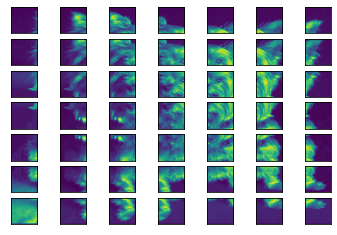

In [9]:
import matplotlib.pyplot as plt

# print(patch.shape)
# plt.imshow(patch)

rows = len(chopped)
# rows = 1
cols = len(chopped[0])
# print('rows, cols', rows, cols)

fig,axes = plt.subplots(rows, cols, squeeze=False)

for i, row in enumerate(np.array(chopped, dtype='int32')):
    # print(i, row)
    for j, col in enumerate(row):
        # print(j, col)
        patch = getpatch(full, col)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        axes[i,j].imshow(patch)

plt.show()

Prep data

In [10]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train_orig.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test_orig.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


Build SIFT model

In [11]:
from tensorflow.keras.layers.experimental import preprocessing


def build_model(num_classes=NUM_CLASSES, lr=1e-3):
    inputs = tf.keras.Input(shape=(PATCH_SIZE, PATCH_SIZE, 1))
    # z = img_augmentation(inputs)
    sift = getSIFTModel(inputs)
    x = sift.output

    # Freeze the pretrained weights
    sift.trainable = False

    # Add accordion-style top, trains faster
    x = tf.keras.layers.Dense(NUM_CLASSES//2, activation="relu")(x)
    x = tf.keras.layers.Dense(NUM_CLASSES//4, activation="relu")(x)
    x = tf.keras.layers.Dense(NUM_CLASSES//2, activation="relu")(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="SIFTPatch")
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [12]:
model = build_model(num_classes=NUM_CLASSES)
model.summary()
print(model)
# print(dir(model))

earlystopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

epochs = 80  # @param {type: "slider", min:1, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2, callbacks=[earlystopping])
print('Evaluate:', model.evaluate(ds_test))


Model: "SIFTPatch"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 65, 65, 1)]  0                                            
__________________________________________________________________________________________________
gx_934931 (Conv2D)              (None, 63, 65, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
gy_408117 (Conv2D)              (None, 65, 63, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 65, 65, 1)    0           gx_934931[0][0]                  
__________________________________________________________________________________________

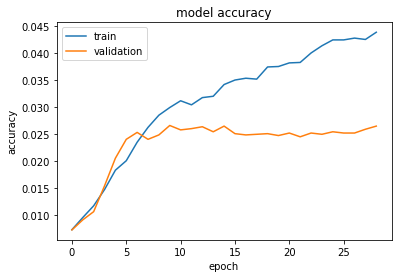

In [13]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)